# Introduction
When searching for potential reads on Goodreads, title and average rating are among the first factors book lovers look at. This report aims to explore their connections, specifically whether books with different titles’ lengths receive different ratings. Because most Goodreads books are published in English, the analysis narrows down to answer the question: 

> Is there any significant evidence that English long-titled books on Goodreads accumulate different ratings from short-titled ones? 
    
By performing **a difference of mean test and constructing confidence intervals**, the report provides some insights into the performance of English books on Goodreads by their title lengths.

See hypotheses below.

# Dataset
The analysis uses a random sample of 200 books from the “Goodreads-books” dataset on Kaggle (Dasgupta, 2020). The original dataset contains over 10,000 Goodreads books, listing their titles, authors, language code, and average rating. The 200-book sample inherits these variables. 

## Cleaning & Preparing Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

data = pd.read_csv('sampled-books.csv')
data

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,157,Anna Karenina,Leo Tolstoy/Constance Garnett/Amy Mandelker,4.05,1593081774,9781593081775,eng,803,303,48,8/26/2004,Barnes & Noble
1,570,HTML XHTML and CSS (Visual Quickstart Guide),Elizabeth Castro,3.80,321430840,9780321430847,en-US,456,549,42,8/1/2006,Peachpit Press
2,848,No Price Too High: A Pentecostal Preacher Beco...,Alex C. Jones/Diane M. Hanson/Stephen K. Ray,4.27,898709199,9780898709193,en-GB,259,51,7,4/30/2006,Ignatius Press
3,866,Fullmetal Alchemist Vol. 9 (Fullmetal Alchemis...,Hiromu Arakawa/Akira Watanabe,4.57,142150460X,9781421504605,eng,192,9013,153,9/19/2006,VIZ Media LLC
4,870,Fullmetal Alchemist Vol. 1 (Fullmetal Alchemis...,Hiromu Arakawa/Akira Watanabe,4.50,1591169208,9781591169208,eng,192,111091,1427,5/3/2005,VIZ Media LLC
...,...,...,...,...,...,...,...,...,...,...,...,...
195,44790,Lo único que no podrás hacer en el cielo,Mark Cahill,4.13,964366568,9780964366565,spa,255,15,0,3/1/2007,Mark Cahill Ministries
196,45101,The Mad Ship (Liveship Traders #2),Robin Hobb,4.23,6498868,9780006498865,eng,906,38753,893,2/4/2008,Harper Voyager
197,45455,Artemis Fowl (Artemis Fowl #1),Eoin Colfer/Ana Alcaina,3.84,8497939204,9788497939201,spa,286,45,3,3/30/2006,DEBOLS!LLO
198,45604,Narraciones Extraordinarias,Edgar Allan Poe,4.13,9583006408,9789583006401,spa,316,36,4,6/1/2004,Panamericana Editorial


### Filter out non-English books

Because the question only concerns English books, 11 non-English titles are filtered using `language_code`. 

In [2]:
#get available languages of books for this dataset 

langs = list(data.language_code.unique())
langs

['eng', 'en-US', 'en-GB', 'jpn', 'rus', 'fre', 'zho', 'spa']

In [3]:
#filter only English titles

eng_lang = langs[:3]
eng_data = data[data["language_code"].isin(eng_lang)].reset_index(drop = True)
print(eng_data.shape) #-> successfully filter 11 non-English titles (num of row drops from 200 to 189)

(189, 12)


### Drop duplicates
Duplicates are removed if they have the same ISBN13 and ISBN, unique identifiers for books. 

In [4]:
#drop duplicates based on ISBN13 - unique identifier of books. 
#keep the last book among duplicates

unique_eng_data = eng_data.drop_duplicates(subset = ['isbn13', 'isbn'], 
                                           keep = 'last').reset_index(drop = True)
print(unique_eng_data.shape)

(189, 12)


### Calculate the length of book titles

In [5]:
#create a new dataframe based on title & average_rating only
df = unique_eng_data.iloc[:, [1, 3]] 
df.head()

,title,average_rating
0,Anna Karenina,4.05
1,HTML XHTML and CSS (Visual Quickstart Guide),3.80
2,No Price Too High: A Pentecostal Preacher Beco...,4.27
3,Fullmetal Alchemist Vol. 9 (Fullmetal Alchemis...,4.57
4,Fullmetal Alchemist Vol. 1 (Fullmetal Alchemis...,4.50


In [6]:
#insert a new column in df for title_length variable

def get_length(string): #calculate the number of words in a title
    word_lst = string.split(" ")
    return int(len(word_lst))

title_leng = [get_length(title) for title in list(df.title)]

#insert a new column as the second column in the dataframe
df.insert(1, "title_length", title_leng, True)
df

,title,title_length,average_rating
0,Anna Karenina,2,4.05
1,HTML XHTML and CSS (Visual Quickstart Guide),7,3.80
2,No Price Too High: A Pentecostal Preacher Beco...,21,4.27
3,Fullmetal Alchemist Vol. 9 (Fullmetal Alchemis...,7,4.57
4,Fullmetal Alchemist Vol. 1 (Fullmetal Alchemis...,7,4.50
...,...,...,...
184,The Drifters,2,4.04
185,A Long Way Gone: Memoirs of a Boy Soldier,9,4.16
186,True Blue: The Oxford Boat Race Mutiny,7,4.24
187,The Roald Dahl Omnibus: Perfect Bedtime Storie...,10,4.35


# Sample Summary Statistics

In [7]:
def roundn(num):
    return round(num, 4)

In [8]:
#get summary statistics for columns with numeric values in df (title_length & average_rating)
sample_stats_df = roundn(df.describe())
sample_stats_df

,title_length,average_rating
count,189.0000,189.0000
mean,6.0212,3.9425
std,3.5204,0.2917
min,1.0000,2.5500
25%,3.0000,3.7900
50%,6.0000,3.9800
75%,8.0000,4.1100
max,21.0000,4.5700


Mode: 3


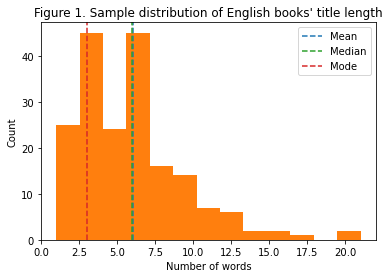

In [9]:
#draw sample distributions for title_length
mean_title_leng = sample_stats_df.title_length[1]
median_title_leng = sample_stats_df.title_length[5]
mode_title_leng = stats.mode(title_leng)[0][0]

print("Mode:", mode_title_leng)

plt.hist(title_leng, bins = 13, color = "tab:orange")
plt.axvline(mean_title_leng, label = "Mean", ls = "--", c = "tab:blue")
plt.axvline(median_title_leng, label = "Median", ls = "--", c = "tab:green")
plt.axvline(mode_title_leng, label = "Mode", ls = "--", c = "tab:red")
plt.title("Figure 1. Sample distribution of English books' title length")
plt.xlabel("Number of words")
plt.ylabel("Count")
plt.legend()
plt.show()

Mode: 4.07


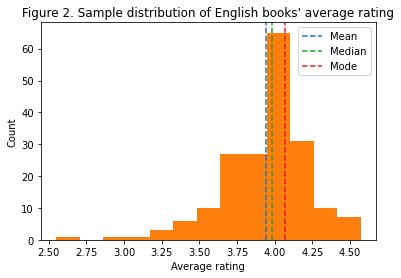

In [10]:
#draw sample distribution for average_rating
mean_avg_rating = sample_stats_df.average_rating[1]
median_avg_rating = sample_stats_df.average_rating[5]
mode_avg_rating = stats.mode(df.average_rating)[0][0]

print("Mode:", mode_avg_rating)

plt.hist(df.average_rating, bins = 13, color = "tab:orange")
plt.axvline(mean_avg_rating, label = "Mean", ls = "--", c = "tab:blue")
plt.axvline(median_avg_rating, label = "Median", ls = "--", c = "tab:green")
plt.axvline(mode_avg_rating, label = "Mode", ls = "--", c = "tab:red")
plt.title("Figure 2. Sample distribution of English books' average rating")
plt.xlabel("Average rating")
plt.ylabel("Count")
plt.legend()
plt.show()

# Hypotheses

Because medians are relatively resistant to outliers, we choose the median of `title_length` as a baseline to define short and long titles. With median = 6.0, it splits the sample into subgroups of short-titled books (<6 words) and long-titled books (≥6 words). 

We perform the significance test for the difference of means to address whether ratings are different for English books with long titles versus short titles. Since the question concerns any difference regardless of direction, it necessitates two-sided tests, which make inferences about the population means of two subgroups, formulated as the following:

- Null hypothesis: There is no difference in average rating for English books with short (<6 words) and long titles (≥6 words). 

$$H_0: \mu_{\text{long-titled book rating}} - \mu_{\text{short-titled book rating}} = 0$$

- Alternative hypothesis: There is a difference in average rating for English books with short (<6 words) and long titles (≥6 words). 

$$H_A: \mu_{\text{long-titled book rating}} - \mu_{\text{short-titled book rating}} \neq 0$$

Since there are no known risks for making Type I or Type 2 errors, we set the significance level, the probability of making Type I error, to the default $\alpha = 0.05$. Bonferroni correction is unnecessary because it performs only one test on the sample. 

# Subgroups Summary Statistics

In [11]:
short_tit_df = df[df.title_length < median_title_leng].reset_index(drop = True)
long_tit_df = df[df.title_length >= median_title_leng].reset_index(drop = True)

short_tit_rating = list(short_tit_df.average_rating)
long_tit_rating = list(long_tit_df.average_rating)

In [12]:
def get_mode(lst):
    '''
     #scipy.stats.mode returns an array of modes and their corresponding occurences. 
     Here we only need the mode number, so [0][0] is used to get that mode.

    '''
    return stats.mode(lst)[0][0]
   
def get_std(lst):
    return np.std(lst, ddof = 1) 
    #ddof = 1 signifies that we're using the sample SD formula (using n-1) 

def get_range(lst):
    return np.max(lst) - np.min(lst)

def descriptive_stats(data_lst, label_lst):
    stats = {"Count": [len(data) for data in data_lst],
             "Mean": [np.mean(data) for data in data_lst], 
             "Median": [np.median(data) for data in data_lst],
             "Mode": [get_mode(data) for data in data_lst],
             "SD" : [get_std(data) for data in data_lst],
             "Range": [get_range(data) for data in data_lst]}
    
    #create dataframe from the dictionary for neat display
    stats_df = pd.DataFrame.from_dict(stats, orient = 'index', columns = label_lst)
    return stats_df

stats_df = descriptive_stats([short_tit_rating, long_tit_rating], 
                             ["short-titled_book_rating", "long-titled_book_rating"])

roundn(stats_df) #round every number in the dataframe to 4 decimal places

,short-titled_book_rating,long-titled_book_rating
Count,94.0000,95.0000
Mean,3.8904,3.9941
Median,3.9700,4.0000
Mode,3.8400,3.7900
SD,0.2826,0.2929
Range,1.4400,2.0200


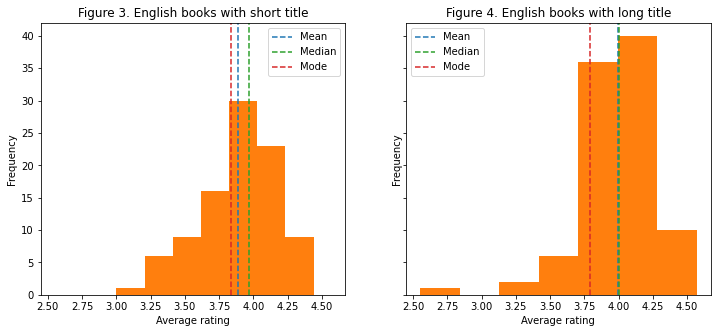

In [13]:
num_bins = 7
subgroups = [short_tit_rating, long_tit_rating]
labels = ["Figure 3. English books with short title", 
          "Figure 4. English books with long title"]

def draw_double_hist(num_bins, x_axis, data_lst, titles_lst):
    #create a plotting area with 2 figure placeholders that share x- and y-axis
    fig, axs = plt.subplots(1, 2, figsize=(12,5), 
                            sharex = True, sharey = True)
    
    #draw two histograms with similar anatomies
    for i in range(2):
        data = data_lst[i]
        axs[i].hist(data, bins = num_bins, color = "tab:orange")
        axs[i].axvline(np.mean(data), 
                       c = "tab:blue", ls = "--", label = "Mean")
        axs[i].axvline(np.median(data), 
                       c = "tab:green", ls = "--", label = "Median")
        axs[i].axvline(get_mode(data), 
                       c = "tab:red", ls = "--", label = "Mode")
        axs[i].legend()
        axs[i].title.set_text(titles_lst[i])
    
    #set labels for x- and y-axis for both histograms
    for ax in axs.flat:
        ax.set(xlabel = x_axis, ylabel = 'Frequency')

draw_double_hist(num_bins, "Average rating", subgroups, labels)

# Statistical Testing

## Conditions for Inference
Since the population standard deviation is unknown, sample standard deviation is used to estimate the standard error for the difference of means. It necessitates the use of t-distribution to model the corresponding sampling distribution. Before proceeding with this choice, conditions for t-distribution approximation must be met:

- **Randomness**: Data for subgroups come from the same random sample.
- **Independence**: Data in each subgroup are sampled without replacement, but with size <10% of the population of English books on Goodreads, so it's fine to assume independence. Each book in one subgroup is unrelated to another in the other, so subgroups are likely unpaired. Therefore, data are *approximately* independent within and between subgroups. 
- **Normality**: Both subgroups have over 30 data points (sample size > 90). Distributions in figures 3 and 4 show no extreme outliers; in fact, they are relatively normal, therefore we may assume the same about the population. 

As these conditions are met, the Central Limit Theorem ensures the sampling distribution of the difference in means would be approximately normal, possibly resulting in over- or under-estimating the difference of means between subgroups.

## Difference of Means Test
After confirming conditions for inference, we compute statistical and practical inference for a difference of means test, with steps and results carried out below.

In [14]:
alpha = 0.05 #significance level

def difference_of_means_test(data1,data2, num_tails):
    #calculate sample size, mean, standard deviations for two datasets
    n1, n2 = len(data1), len(data2)
    x1, x2 = np.mean(data1), np.mean(data2)
    s1, s2 = get_std(data1), get_std(data2)

    #calculate SE to get t-score 
    standard_error = np.sqrt(s1**2/n1 + s2**2/n2)
    tscore = (x2 - x1)/ standard_error
    degree_of_freedom = min(n1, n2) - 1 #conservative estimate
    
    #convert t-score and its df to p-value
    pvalue = num_tails * stats.t.sf(abs(tscore), degree_of_freedom)

    pooled_SD = np.sqrt((s1**2*(n1-1) + s2**2*(n2-1))/(n1+n2-2)) # OpenIntro section 5.3.6
    cohensd = (x2 - x1)/pooled_SD
    hedgesg = cohensd * (1 - 3/(4*n1 + 4*n2 - 9))
    
    significance_dict = {"SE": roundn(standard_error), 
                         "t-score" : roundn(tscore), 
                         "df": degree_of_freedom,
                         "p-value": roundn(pvalue), 
                         "pooled SD": roundn(pooled_SD),
                         "Cohen's d": roundn(cohensd),
                         "Hedge's g": roundn(hedgesg)}
    return significance_dict

significance_dict = difference_of_means_test(short_tit_rating, long_tit_rating, 2)
significance_dict

{'SE': 0.0419,
 't-score': 2.4764,
 'df': 93,
 'p-value': 0.0151,
 'pooled SD': 0.2878,
 "Cohen's d": 0.3602,
 "Hedge's g": 0.3588}

In [15]:
def assess_stats_significance(significance_level, pvalue):
    if pvalue < significance_level:
        return "reject null hypothesis"
    else:
        return "fail to reject null hypothesis"

assess_stats_significance(alpha, significance_dict['p-value'])

'reject null hypothesis'

Because $p\approx0.0151 < \alpha=0.05$, the significance level, we reject the null hypothesis and conclude the data favors the alternative hypothesis: 

> There is indeed EVIDENCE FOR a difference in ratings for English books with long (≥ 6 words) and short titles (<6 words) on Goodreads. 
    
However, a measure of effect size is needed to assess practical significance. When the sample sizes for subgroups are reasonably large (>90), the correction effect of $\text{Hedge’s } g$ for $\text{Cohen’s } d$ is less noticeable than when sample sizes are small (<30). Therefore, we use $\text{Cohen’s } d$ as our measure.

In [16]:
def assess_practical_significance(effect_size):
    effect_size = abs(effect_size)
    if effect_size > 0.8:
        return "large size effect"
    elif effect_size > 0.5:
        return "medium size effect"
    else:
        return "small size effect"
    
assess_practical_significance(significance_dict["Cohen's d"])

'small size effect'

As calculated, $\text{Cohen’s } d \approx 0.3602$, which signifies a small effect size.

> This effect size shows that the average ratings of long-titled English books are slightly higher than those of short-titled books.

## Confidence Interval for Difference of Means

In [21]:
confidence_lv = 1 - alpha
                       
def single_mean_ci(confidence_level, data):
    sample_size = len(data)
    sample_mean = np.mean(data)
    sample_SD = get_std(data)
    
    #calculate t-score from the confidence level and its degrees of freedom
    degree_of_freedom = sample_size - 1
    percentile = 1 - (1 - confidence_level)/ 2 #area under the curve excludes the right tail
    tscore = stats.t.ppf(percentile, degree_of_freedom)
    
    #calculate the SE for sample mean and ME 
    standard_error = sample_SD / (sample_size ** 0.5)
    margin_of_error = tscore * standard_error
    
    low_bound = roundn(sample_mean - margin_of_error)
    high_bound = roundn(sample_mean + margin_of_error)
    
    return np.array([low_bound, high_bound])

For intervals of subgroups, we can be 95% confident that each population mean of average rating would fall into the corresponding range. 

In [25]:
ci_short = single_mean_ci(confidence_lv, short_tit_rating)
print(f'Confidence interval for short-titled books: {ci_short}')

Confidence interval for short-titled books: [3.8325 3.9483]


In [29]:
ci_long = single_mean_ci(confidence_lv, long_tit_rating)
print(f'Confidence interval for long-titled books: {ci_long}')

Confidence interval for long-titled books: [3.9344 4.0538]


In [30]:
diff_means_ci = ci_long - ci_short
print(f'Confidence interval for diffence in means: {diff_means_ci}')

Confidence interval for diffence in means: [0.1019 0.1055]


This confidence interval for difference in means contains 0, the null value for no difference, which agrees with statistical test conducted above.

# Conclusion 

Based on the results for statistical and practical significance test for the average rating between subgroups ($p=0.0151, d=0.3602$), there's evidence to suggest that the average ratings of long-titled English books listed on Goodreads are slightly higher than those of short-titled books.